In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Only lung images
class_map = {
    "lung_aca": 0,
    "lung_n": 1,
    "lung_scc": 2
}
lung_dir = "E:/cancer_dl/LC25000/lung_colon_image_set/lung_image_sets"
all_dirs = [lung_dir]

# Preprocessing (ImageNet normalization, some augmentations)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229,0.224,0.225])
])

class LC25000Dataset(Dataset):
    def __init__(self, root_dirs, class_map, transform=None):
        self.samples = []
        self.transform = transform
        for root in root_dirs:
            for class_name in os.listdir(root):
                folder = os.path.join(root, class_name)
                if os.path.isdir(folder):
                    for img_name in os.listdir(folder):
                        self.samples.append((os.path.join(folder, img_name), class_map[class_name]))
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = Image.open(path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Instantiate dataset & split
dataset = LC25000Dataset(all_dirs, class_map, transform)
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)


In [3]:
print(f"Total dataset size: {len(dataset)}")
print(f"Training set: {len(train_set)} samples ({len(train_set) / len(dataset) * 100:.1f}%)")
print(f"Validation set: {len(val_set)} samples ({len(val_set) / len(dataset) * 100:.1f}%)")
print(f"Test set: {len(test_set)} samples ({len(test_set) / len(dataset) * 100:.1f}%)")


Total dataset size: 15000
Training set: 10500 samples (70.0%)
Validation set: 3000 samples (20.0%)
Test set: 1500 samples (10.0%)


In [7]:
import torch.nn as nn
from torchvision.models import convnext_tiny, swin_t

class ConvNeXtEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        backbone = convnext_tiny(weights='IMAGENET1K_V1')
        self.features = backbone.features
        self.pool = nn.AdaptiveAvgPool2d(1)
    def forward(self, x):
        x = self.features(x)
        return self.pool(x).flatten(1)

class SwinEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        backbone = swin_t(weights='IMAGENET1K_V1')
        self.features = backbone.features
        self.norm = backbone.norm
        self.avgpool = nn.AdaptiveAvgPool1d(1)
    def forward(self, x):
        x = self.features(x)
        x = x.permute(0, 3, 1, 2)
        x = x.flatten(2)
        x = x.permute(0, 2, 1)
        x = self.norm(x)
        x = x.permute(0, 2, 1)
        x = self.avgpool(x)
        return x.squeeze(-1)

class HybridClassifier(nn.Module):
    def __init__(self, num_classes=3):  # For lung dataset
        super().__init__()
        self.cnn = ConvNeXtEncoder()
        self.swin = SwinEncoder()
        self.fusion = nn.Sequential(
            nn.Linear(1536, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        cnn_feat = self.cnn(x)
        swin_feat = self.swin(x)
        feats = torch.cat([cnn_feat, swin_feat], dim=1)
        return self.fusion(feats)


In [9]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Training setup
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HybridClassifier(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# Lists to store metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = 100. * correct / total

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_loss = val_loss / len(val_loader.dataset)
    val_acc = 100. * val_correct / val_total

    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Step scheduler
    scheduler.step()

    # Print epoch results
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Early stop if training accuracy is very high
    if epoch_acc >= 99.95:
        print(f"🎉 Training accuracy reached {epoch_acc:.2f}% — stopping early.")
        break


Epoch [1/10], Train Loss: 0.3850, Train Acc: 95.24%, Val Loss: 0.3277, Val Acc: 98.03%
Epoch [2/10], Train Loss: 0.3207, Train Acc: 98.83%, Val Loss: 0.2963, Val Acc: 99.77%
Epoch [3/10], Train Loss: 0.3028, Train Acc: 99.69%, Val Loss: 0.3080, Val Acc: 99.17%
Epoch [4/10], Train Loss: 0.2972, Train Acc: 99.93%, Val Loss: 0.2946, Val Acc: 99.87%
Epoch [5/10], Train Loss: 0.2960, Train Acc: 99.92%, Val Loss: 0.2943, Val Acc: 99.93%
Epoch [6/10], Train Loss: 0.3021, Train Acc: 99.59%, Val Loss: 0.2927, Val Acc: 99.93%
Epoch [7/10], Train Loss: 0.2949, Train Acc: 99.96%, Val Loss: 0.2917, Val Acc: 100.00%
🎉 Training accuracy reached 99.96% — stopping early.


In [10]:
# Generate classification report on test set
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

# Print classification report
print("\n" + "="*50)
print("           CLASSIFICATION REPORT")
print("="*50)
target_names = ['lung_aca', 'lung_n', 'lung_scc']
print(classification_report(all_targets, all_preds, target_names=target_names))



           CLASSIFICATION REPORT
              precision    recall  f1-score   support

    lung_aca       1.00      1.00      1.00       505
      lung_n       1.00      1.00      1.00       478
    lung_scc       1.00      1.00      1.00       517

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500



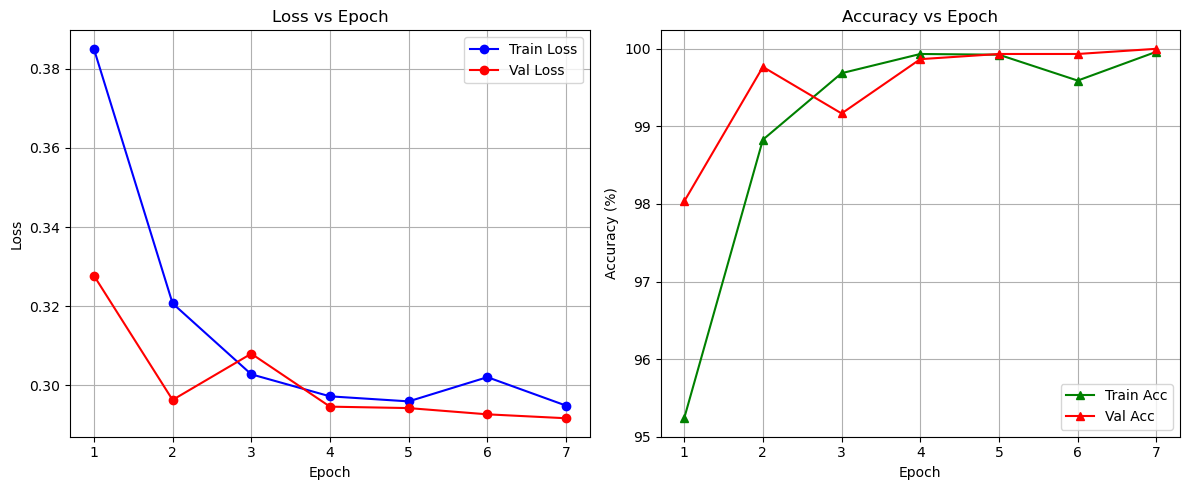

In [13]:
epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'bo-', label='Train Loss')
plt.plot(epochs, val_losses, 'ro-', label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss vs Epoch')
plt.legend(); plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'g^-', label='Train Acc')
plt.plot(epochs, val_accuracies, 'r^-', label='Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy (%)'); plt.title('Accuracy vs Epoch')
plt.legend(); plt.grid(True)

plt.tight_layout()
plt.show()


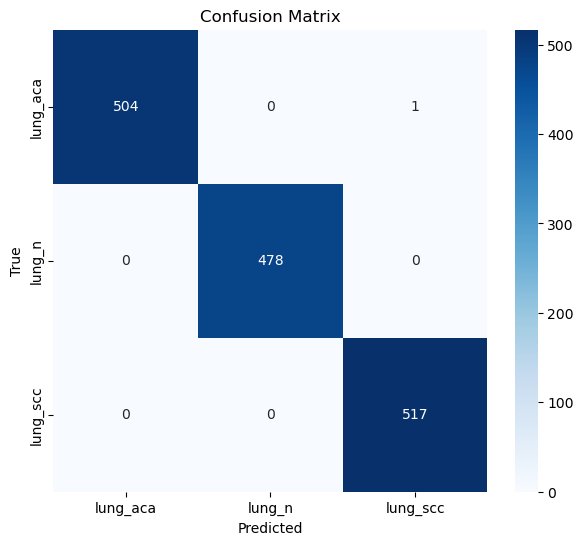

In [15]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Get model predictions and true labels (run after training)
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

# Step 2: Compute confusion matrix
cm = confusion_matrix(all_targets, all_preds)

# Step 3: Visualize with seaborn
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['lung_aca', 'lung_n', 'lung_scc'],
            yticklabels=['lung_aca', 'lung_n', 'lung_scc'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [17]:
# Save entire model
torch.save(model.state_dict(), "hybrid_lung_model.pth")
print("Model saved as hybrid_lung_model.pth")

# To load later:
# model = HybridClassifier(num_classes=3)
# model.load_state_dict(torch.load("hybrid_lung_model.pth"))


Model saved as hybrid_lung_model.pth


In [ ]:
import torch
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# --- STEP 1: Collect Predicted Probabilities and True Labels ---
model.eval()
all_probs = []
all_targets = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)                    # [batch, n_classes]
        probs = torch.softmax(outputs, dim=1)      # [batch, n_classes]
        all_probs.extend(probs.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())
all_probs = np.array(all_probs)

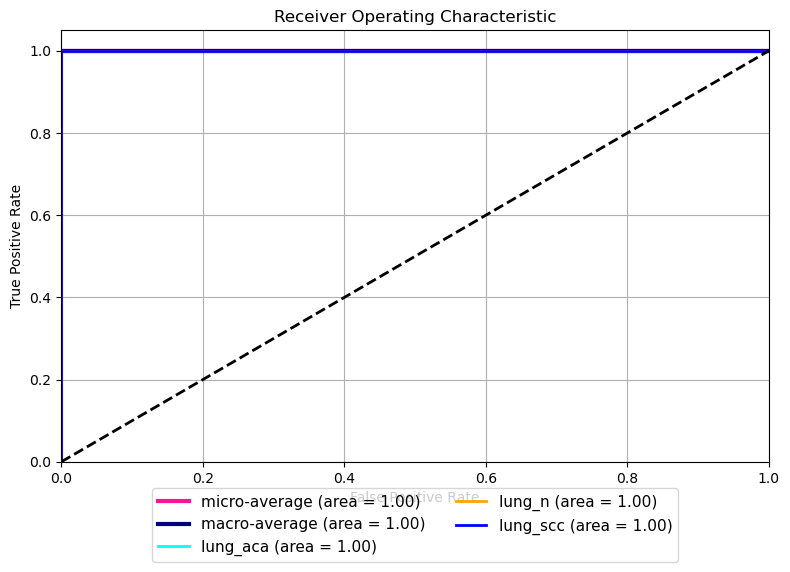

In [23]:
# Block 2: Multi-class ROC curve (publication legend)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

n_classes = 3
y_true_bin = label_binarize(all_targets, classes=[0,1,2])

fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:,i], all_probs[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro/macro averages
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), all_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize=(8,7))
plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle='-', linewidth=3,
         label=f'micro-average (area = {roc_auc["micro"]:.2f})')
plt.plot(fpr["macro"], tpr["macro"], color='navy', linestyle='-', linewidth=3,
         label=f'macro-average (area = {roc_auc["macro"]:.2f})')
colors = ['cyan', 'orange', 'blue']
classes = ['lung_aca', 'lung_n', 'lung_scc']
for i, color, name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'{name} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.25), ncol=2, frameon=True, fontsize=11)
plt.grid(True)
plt.tight_layout(rect=[0, 0.13, 1, 1])
plt.savefig("lung_roc_curve.png", dpi=300)
plt.show()


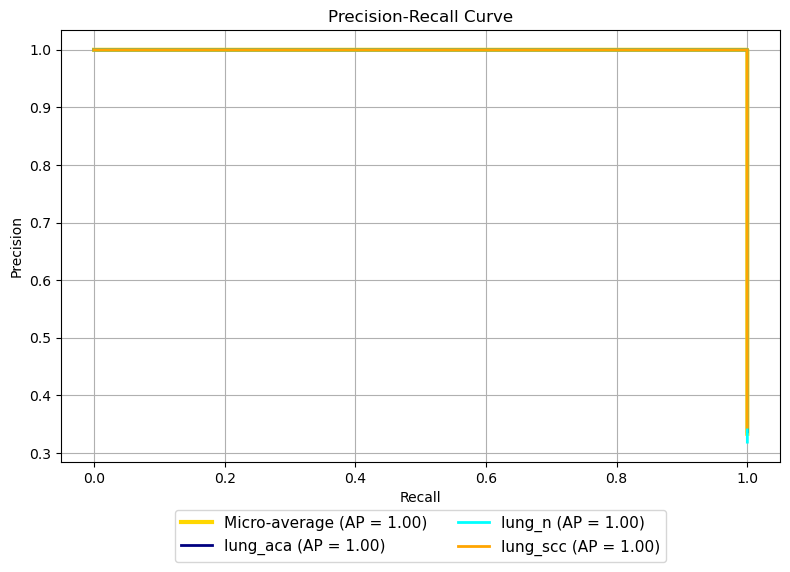

In [25]:
# Block 3: Multi-class Precision-Recall curve
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(8,7))
# Micro-average
precision, recall, _ = precision_recall_curve(y_true_bin.ravel(), all_probs.ravel())
ap_micro = average_precision_score(y_true_bin, all_probs, average="micro")
plt.plot(recall, precision, color='gold', lw=3, label=f"Micro-average (AP = {ap_micro:.2f})")

# Individual class curves
colors = ['navy', 'cyan', 'orange']
for i, color, name in zip(range(n_classes), colors, classes):
    precision, recall, _ = precision_recall_curve(y_true_bin[:,i], all_probs[:,i])
    ap = average_precision_score(y_true_bin[:,i], all_probs[:,i])
    plt.plot(recall, precision, color=color, lw=2, label=f"{name} (AP = {ap:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.25), ncol=2, frameon=True, fontsize=11)
plt.grid(True)
plt.tight_layout(rect=[0, 0.13, 1, 1])
plt.savefig("lung_pr_curve.png", dpi=300)
plt.show()
